In [285]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### Instructions

Your case study is to build a classifier using logistic regression to predict hospital readmittance. 
There is missing data that must be imputed. Once again, discuss variable importances as part of your submission.

### Team:
- Dylan Scott
- Jobin Joseph
- Taylor Bonar
- Satvik Ajmera

In [286]:
#data
diabetes_df = pd.read_csv("../dataset_diabetes/diabetic_data.csv", header=0, na_values="?", low_memory=False)
diabetes_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [287]:
diabetes_df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [288]:
diabetes_df['age'].value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [289]:
age_values = list(diabetes_df['age'].unique())

In [290]:
diabetes_df['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [291]:
#value dictionaries
Race = {'Caucasian':0, 'AfricanAmerican':1, 'Hispanic':2,'Other':3,'Asian':4, np.nan:5}
Gender = {'Male': 1,'Female': 0,'Unknown/Invalid':3}
Age = {}
count = 0
for i in range(len(age_values)):
    Age[age_values[i]] = count
    count+=1

diabetes_df.race = [Race[item] for item in diabetes_df.race]
diabetes_df.gender = [Gender[item] for item in diabetes_df.gender]
diabetes_df.age = [Age[item] for item in diabetes_df.age]
diabetes_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,0,0,0,NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,0,0,1,NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,1,0,2,NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,0,1,3,NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,0,1,4,NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


<function matplotlib.pyplot.show(close=None, block=None)>

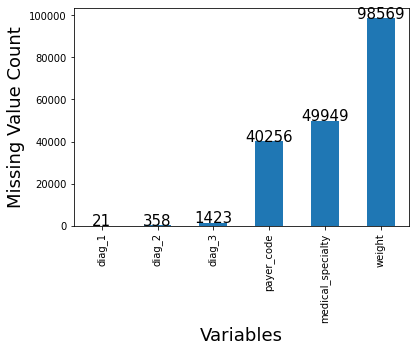

<Figure size 720x1800 with 0 Axes>

In [292]:

#iterate though all the columns and show all the possible vaules 
#next make sure to actually swap out the values
#but first lets look at missing values
missing = diabetes_df.isna().sum()
missing = pd.DataFrame(missing, columns = ['missing'])
missing = missing[(missing.T !=0).any()]
missing = missing.sort_values('missing')

missing.plot(kind = 'bar', legend = False)
plt.ylabel('Missing Value Count', fontsize=18)
plt.xlabel('Variables', fontsize=18)
plt.xticks(rotation='90')
for index,data in enumerate(missing['missing']):
    plt.text(x=index , y =data+2 , s=f"{data}" , fontdict=dict(fontsize=15), ha='center')
plt.figure(figsize=(10, 25))
plt.show

In [293]:
#per the profs recc we should drop wight since it is missing for more than half the dataset
#drop weight, payer code and medical spec
diabetes_df = diabetes_df.drop(columns=['weight','payer_code','medical_specialty'])
#diabetes_df = diabetes_df.drop(columns=['encounter_id','patient_nbr'])
diabetes_df = diabetes_df.drop(columns=['encounter_id'])
#diabetes_df = diabetes_df.drop(columns=['diag_1','diag_2','diag_3'])
diabetes_df = diabetes_df.loc[~diabetes_df.discharge_disposition_id.isin([11,13,14,19,20,21])]
readmitted = {'<30':2,'NO':1,'>30':3}
diabetes_df.readmitted = [readmitted[item] for item in diabetes_df.readmitted]
#diabetes_df = diabetes_df.drop_duplicates(keep="last",subset="patient_nbr")
diabetes_df = diabetes_df.dropna()
#should we fill in the unknown race?
diabetes_df['race'].fillna('Caucasian')
final_df = diabetes_df.drop(columns = ["patient_nbr"])
final_df.head(1)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,0,0,1,1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,3


In [294]:

final_df.isna().sum()


race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide

In [295]:
#pd get dummies

#number cols
numeric_features = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']
#categorical vars
categorical_features = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']


In [296]:
X = diabetes_df.drop(columns=['readmitted']).copy()
y = diabetes_df['readmitted'].values.copy()
#X_scaled = pd.get_dummies(X)

In [297]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler(with_mean=False))])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop="first"))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_scaled = pipeline.fit_transform(X)

In [298]:
# X= X.values
# y= y.values
np.bincount(y)

array([    0, 51488, 11207, 35130], dtype=int64)

In [299]:
from sklearn.model_selection import StratifiedShuffleSplit 
sss_cv = StratifiedShuffleSplit(n_splits=5,test_size=0.20, random_state=42)

In [300]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
import time

lr_clf = LogisticRegression(multi_class = "multinomial",max_iter=5000, random_state=1000)

iter_num=0

for train_indices, test_indices in sss_cv.split(X_scaled,y): 
    X_train = X_scaled[train_indices]
    y_train = y[train_indices]
    
    X_test = X_scaled[test_indices]
    y_test = y[test_indices]
    lr_clf.fit(X_train,y_train)  # train object

    y_hat = lr_clf.predict(X_test) # get test set predictions
    print("====Iteration",iter_num," ====")
    acc = mt.accuracy_score(y_test,y_hat)
    print('Accuracy:', acc)
    iter_num+=1

====Iteration 0  ====
Accuracy: 0.5673907487860976
====Iteration 1  ====
Accuracy: 0.5642218246869409
====Iteration 2  ====
Accuracy: 0.5676974188602095
====Iteration 3  ====
Accuracy: 0.5602351137234858
====Iteration 4  ====
Accuracy: 0.565704063378482
CPU times: total: 13min 54s
Wall time: 5min 52s


In [301]:
# %%time
# from sklearn.model_selection import GridSearchCV
# regEstimator = LogisticRegression(multi_class = "multinomial")

# parameters = { 'penalty':['l1','l2']
#               ,'C': [0.001, 0.01, 0.1]
#               ,'random_state': [42]
#               ,'solver': ['saga']
#               ,'max_iter':[5000]
#              }


# GridSearch = GridSearchCV(estimator=regEstimator
#                    , verbose=3
#                    , param_grid=parameters
#                    , cv=sss_cv 
#                    , scoring='accuracy')

# GridSearch.fit(X_scaled, y)

In [302]:
#lr_best_est = GridSearch.best_estimator_
lr_best_est = LogisticRegression(C=0.001, max_iter=5000, multi_class='multinomial',
                   random_state=42, solver='saga',penalty='l2')
#END C=0.01, max_iter=5000, penalty=l2, random_state=42, solver=saga;, score=0.745 total time= 3.2min
#{'C': 0.001, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
#END C=0.1, max_iter=5000, penalty=l1, random_state=42, solver=saga;, score=0.745 total time= 5.0min
print(lr_best_est)

LogisticRegression(C=0.001, max_iter=5000, multi_class='multinomial',
                   random_state=42, solver='saga')


In [303]:
#print('Highest Accuracy', GridSearch.best_score_ )

In [304]:
#best_params = GridSearch.best_params_
#print(best_params)

In [305]:
from sklearn.model_selection import cross_val_predict
pred = cross_val_predict(lr_best_est,X_test,y_test, cv=5)

<function matplotlib.pyplot.show(close=None, block=None)>

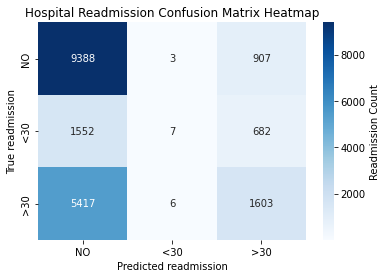

In [306]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)
x_axis_labels = ['NO','<30', '>30']
y_axis_labels = ['NO','<30', '>30']
ax = plt.axes()
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d',xticklabels=x_axis_labels,
            yticklabels=y_axis_labels, ax=ax, cbar_kws={'label': 'Readmission Count',})
ax.set_title('Hospital Readmission Confusion Matrix Heatmap')
plt.xlabel("Predicted readmission")
plt.ylabel("True readmission") 
plt.show

In [307]:
#run final model for feature importance 
final_mod = lr_best_est.fit(X_train,y_train)
final_mod.score(X_test,y_test)

0.5651418349092767

In [308]:
#get the best index for feature importance
feature_names = pd.DataFrame(X_scaled)
feature_names = feature_names.columns.values
feature_importances = pd.DataFrame(final_mod.coef_[0],index = feature_names,columns=['importance']).sort_values('importance',ascending=False)

In [309]:
feature_names

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70], dtype=int64)

In [310]:
final_mod.coef_[0]

array([-3.26175868e-02, -3.04827451e-02,  4.50099839e-02, -1.11108209e-02,
       -5.79140509e-02, -1.27075731e-01, -3.29383708e-01, -1.04499927e-01,
        2.03385689e-02,  3.88199642e-02,  4.67894107e-02,  3.25314909e-02,
        1.02636489e-01,  2.08212384e-02,  5.89264789e-04, -4.22012786e-02,
        3.77390552e-02,  2.66645992e-02, -4.48786874e-03, -5.80843517e-02,
        4.75036955e-02, -6.45987472e-02,  4.06878584e-02,  2.76802833e-02,
        2.48493728e-02, -2.56037452e-02,  3.09265945e-03,  5.72102992e-03,
       -5.92489921e-03,  1.40133246e-03,  5.01050699e-03, -1.74178672e-03,
       -1.97568759e-03, -7.01305155e-03,  2.90044025e-03,  7.76588158e-03,
        0.00000000e+00,  2.44911896e-02, -1.11303160e-02, -3.47979031e-03,
       -1.79063664e-03, -9.39118101e-03,  1.53126955e-02,  1.29629951e-03,
        1.29265356e-02, -3.17412961e-03, -7.75336172e-03,  1.23718416e-02,
       -2.74122762e-02,  6.33330015e-03,  1.68527381e-02, -1.41475023e-02,
       -1.78269921e-03,  

In [311]:
feature_importances

,importance
12,0.102636
60,0.065400
20,0.047504
10,0.046789
2,0.045010
...,...
21,-0.064599
7,-0.104500
5,-0.127076
70,-0.131503


In [312]:

numeric_features_new = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                    'num_medications','number_outpatient','number_emergency',
                    'number_inpatient','number_diagnoses']

X_columns = final_df.drop("readmitted", axis = 1).copy()
X_columns = pipeline.fit(X_columns)
X_columns.named_steps["preprocessor"].transformers_[1][1].named_steps["onehot"]
column_name = X_columns.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names_out(categorical_features)

column_name = list(column_name)
column_name[:0] = numeric_features_new
coefficients = pd.concat([pd.DataFrame(column_name),pd.DataFrame(np.transpose(lr_best_est.coef_),columns = ['NO','<30','>30'])], axis = 1)
coefficients = coefficients.rename(columns={0:'Features'})
#coefficients.head(10)

In [313]:
#coefficients = feature_importances.join(coefficients)
# coefficients = coefficients.rename(columns={"importance":'NO'})
# coefficients['Overall Importance ABS'] = coefficients['Overall Importance'].abs()


KeyError: 'Overall Importance'

In [ ]:
# coefficients['Sum_absolute'] = abs(coefficients['Not_Readmitted']) + abs(coefficients['<30']) + abs(coefficients['>30'])
# coefficients = coefficients.sort_values(by='Sum_absolute', key=abs, ascending=False)
# coefficients.reset_index(level=0, inplace=True)

# coefficients.head(10)

TypeError: 'DataFrame' object is not callable

In [ ]:
# coefficients.to_csv(r'C:\Users\drsco\Documents\GitHub\QTW\qtw\case study 2\MethodA_featureImp.csv')

In [ ]:
coefficients

,Not_Readmitted,More_than_30,Less_than_30,<30,>30,Overall Importance ABS
12,0.102636,race_5,0.102636,-0.018522,-0.084114,0.102636
60,0.065400,insulin_Steady,0.065400,-0.019592,-0.045808,0.065400
20,0.047504,A1Cresult_Norm,0.047504,-0.015071,-0.032432,0.047504
10,0.046789,race_3,0.046789,-0.007500,-0.039289,0.046789
2,0.045010,num_procedures,0.045010,-0.014828,-0.030182,0.045010
...,...,...,...,...,...,...
21,-0.064599,metformin_No,-0.064599,0.042383,0.022216,0.064599
7,-0.104500,number_diagnoses,-0.104500,0.043890,0.060610,0.104500
5,-0.127076,number_emergency,-0.127076,0.065869,0.061206,0.127076
70,-0.131503,diabetesMed_Yes,-0.131503,0.053487,0.078016,0.131503
